<a href="https://colab.research.google.com/github/workpiles/soybeans_sorter/blob/master/soybeans_sorter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境構築

### GPU&バージョン確認

GPUインスタンスに接続できているかを確認します．“GPUゲットだぜ！”と表示されれば問題ありません．

ゲットできなかった場合でも，CPUを使って実験を進めることは可能ですが，学習にとても時間がかかります．ゲットできなかった場合は，しばらく時間を置いてから再度接続を試してみて下さい．

In [1]:
import tensorflow as tf

if tf.test.gpu_device_name() == "/device:GPU:0":
  print("GPUゲットだぜ！")
else:
  print("逃した…")

print("TensorFlow:", tf.__version__)

逃した…
TensorFlow: 1.10.1


### 必要パッケージのインポート

最初に使用するパッケージのインポートを行います．

※TF2に対応（2020/03/30)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Activation, Reshape, concatenate, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Conv2D, UpSampling2D, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.decomposition import PCA
import time


### データセット取得

枝豆データセットをダウンロードして，使いやすようにデータを変換しておきます．

画像データは255で割ることにより値が0.0-1.0に収まるように変換します．

ラベルデータは，One-Hot形式に変換します．

(600, 48, 64, 1) (600, 2) (580, 48, 64, 1) (580, 2)


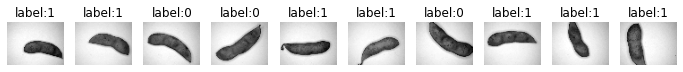

In [3]:
#ダウンロード
!wget "https://github.com/workpiles/soybeans_sorter/raw/master/soybeans_gray.npz" -O soybeans_dataset.npz -q

#ダウンロードしたデータセットの読み込み
IMAGE_HEIGHT = 48
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 1
CLASSES = 2
def load_data():
  data = np.load("soybeans_dataset.npz")
  x_train = data['x_train'].astype('float32') / 255.
  x_test  = data['x_test'].astype('float32') / 255.
  x_train = x_train.reshape([-1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
  x_test  = x_test.reshape([-1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
  y_train = np.eye(CLASSES)[data['y_train']]
  y_test  = np.eye(CLASSES)[data['y_test']]
  return x_train, y_train, x_test, y_test

X_train, y_train, X_test, y_test = load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#画像の確認
fig, ax = plt.subplots(1, 10, figsize=(12, 6))
for i in range(10):
  if IMAGE_CHANNEL == 1:
    ax[i].imshow(X_train[np.random.randint(len(X_train))].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
  else:
    ax[i].imshow(X_train[np.random.randint(len(X_train))])
  ax[i].axis('off')
  ax[i].set_title("label:%d"%(np.argmax(y_train[i])))
plt.show()


# Conditional GANを使ったデータ作り実験

### Generatorの構築

In [0]:
def build_generator():
  noize_input = Input(shape=[100]) #入力は100次元の潜在変数
  cond_input = Input(shape=[CLASSES])    #とラベル
  model_input = concatenate([noize_input, cond_input], axis=1)
  x = Dense(256*6*8, kernel_initializer=RandomNormal(stddev=0.02))(model_input) #102->256*6*8
  x = BatchNormalization(momentum=0.8)(x)
  x = Activation('relu')(x)
  x = Reshape([6, 8, 256])(x) #256*6*8-> 6x8x256
  x = UpSampling2D()(x) #6x8x256->12x16x256
  x = Conv2D(128, kernel_size=5, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #12x16x256->12x16x128
  x = BatchNormalization(momentum=0.8)(x)
  x = Activation('relu')(x)  
  x = UpSampling2D()(x) #12x16x128->24x32x128
  x = Conv2D(64, kernel_size=3, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #24x32x128->24x32x64
  x = BatchNormalization(momentum=0.8)(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x) #24x32x64->48x64x64
  x = Conv2D(32, kernel_size=3, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #48x64x64->48x64x32
  x = BatchNormalization(momentum=0.8)(x)
  x = Activation('relu')(x)
  x = Conv2D(IMAGE_CHANNEL, kernel_size=3, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #48x64x32->48x64x1
  model_output = Activation('sigmoid')(x)
  
  model = Model([noize_input, cond_input], model_output)
  return model

### Discriminatorの構築

In [0]:
def build_discriminator():
  image_input = Input(shape=[IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL]) #入力は画像
  cond_input = Input(shape=[CLASSES])                                 #とラベル
  cond_ = Reshape([1, 1, CLASSES])(cond_input)
  cond_ = UpSampling2D(size=(IMAGE_HEIGHT, IMAGE_WIDTH))(cond_)
  model_input = concatenate([image_input, cond_], axis=-1) #画像とラベルを連結 shape=48x64x3
  x = Conv2D(32, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(model_input) #48x64x3->24x32x32
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.25)(x)
  x = Conv2D(64, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #24x32x32->12x16x64
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.25)(x)
  x = Conv2D(128, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x) #12x16x64->6x8x128
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x) #6x8x128->6*8*128
  x = Dense(256)(x) #6*8*128->256
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.25)(x)
  model_output = Dense(2, activation='softmax')(x) #256->2
  
  model = Model([image_input, cond_input], model_output)
  return model

### 学習モデルの構築

In [0]:
#discriminatorの学習モデル
discriminator = build_discriminator()
discriminator.trainable = True
discriminator.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['acc'])

#generatorの学習モデル
generator = build_generator()
z = Input(shape=[100])
cond = Input(shape=[CLASSES])
gen_image = generator([z, cond])
discriminator.trainable = False
valid = discriminator([gen_image, cond])
combined_model = Model([z, cond], valid)
combined_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['acc'])

def train_gan(max_step=1000, batch_size=32):
  start = time.time()
  datagen = ImageDataGenerator(
    rotation_range=60,
    horizontal_flip=True,
    vertical_flip=True)

  for step in range(max_step):
    #--------------------
    # Discriminatorの学習
    #--------------------
    g = datagen.flow(X_train, y_train, batch_size=batch_size)
    images, labels = g.next()
    
    #バッチサイズ分のノイズから画像を生成する
    noize = np.random.uniform(0, 1, size=[batch_size, 100])
    generated_images = generator.predict([noize, labels])
    X = np.concatenate((images, generated_images))
    y = np.zeros([batch_size*2, 2])
    y[:batch_size, 1] = 1
    y[batch_size:, 0] = 1
    X_labels = np.concatenate((labels, labels))
    d_loss = discriminator.train_on_batch([X, X_labels], y)
    
    #----------------
    # Generatorの学習
    #----------------
    noize = np.random.uniform(0, 1, size=[batch_size, 100])
    g_loss = combined_model.train_on_batch([noize, labels], y[:batch_size,:])    

    if (step+1) % 1000 == 0:
      print("Step %d : g_acc=%f d_acc=%f"%(step+1, g_loss[1], d_loss[1]))
      results = generator.predict([noize, labels])
      fig, ax = plt.subplots(1, 10, figsize=(12,2))
      for i in range(10):
        if IMAGE_CHANNEL == 1:
          ax[i].imshow(results[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
        else:
          ax[i].imshow(results[i])
        ax[i].axis('off')
        ax[i].set_title("label:%d"%(np.argmax(labels[i])))
      plt.show()
      print("Elapsed Time:%fs"%(time.time() - start))

  generator.save('generator.h5')
  discriminator.save('discrimitor.h5')
  combined_model.save('combined_model.h5')
  

Step 1000 : g_acc=0.234375 d_acc=0.750000


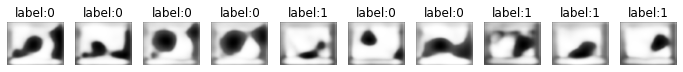

Elapsed Time:89.855622s
Step 2000 : g_acc=0.421875 d_acc=0.617188


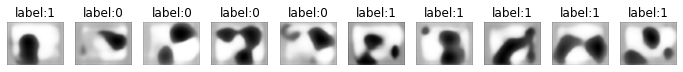

Elapsed Time:171.609105s
Step 3000 : g_acc=0.109375 d_acc=0.812500


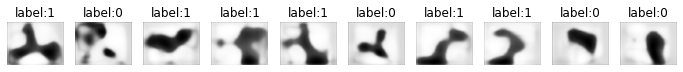

Elapsed Time:253.925267s
Step 4000 : g_acc=0.125000 d_acc=0.828125


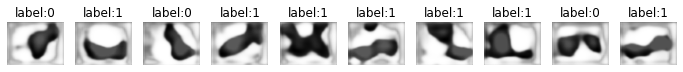

Elapsed Time:335.449996s
Step 5000 : g_acc=0.015625 d_acc=0.882812


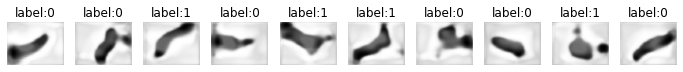

Elapsed Time:417.002865s
Step 6000 : g_acc=0.156250 d_acc=0.656250


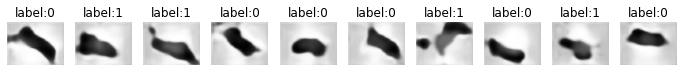

Elapsed Time:498.886617s
Step 7000 : g_acc=0.078125 d_acc=0.625000


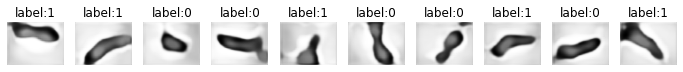

Elapsed Time:580.263850s
Step 8000 : g_acc=0.125000 d_acc=0.804688


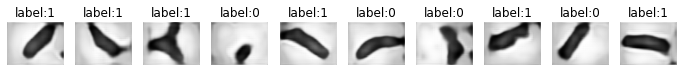

Elapsed Time:661.252334s
Step 9000 : g_acc=0.218750 d_acc=0.632812


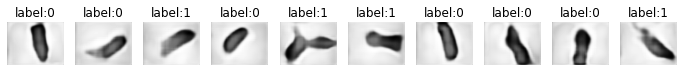

Elapsed Time:742.547645s
Step 10000 : g_acc=0.328125 d_acc=0.578125


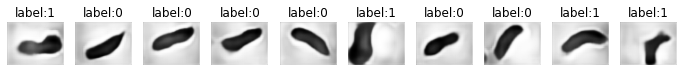

Elapsed Time:823.502907s
Step 11000 : g_acc=0.218750 d_acc=0.664062


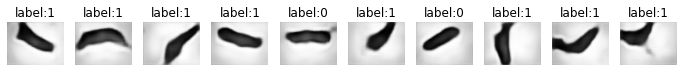

Elapsed Time:904.684183s
Step 12000 : g_acc=0.218750 d_acc=0.632812


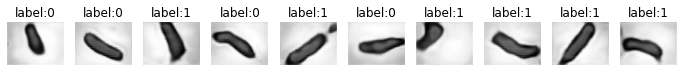

Elapsed Time:985.125017s
Step 13000 : g_acc=0.265625 d_acc=0.671875


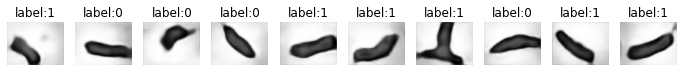

Elapsed Time:1065.201872s
Step 14000 : g_acc=0.281250 d_acc=0.734375


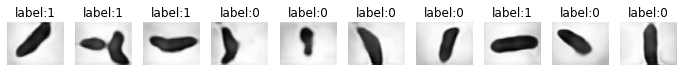

Elapsed Time:1145.415930s
Step 15000 : g_acc=0.281250 d_acc=0.640625


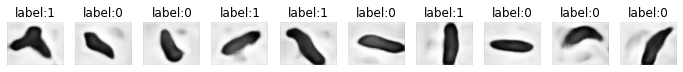

Elapsed Time:1225.209763s
Step 16000 : g_acc=0.390625 d_acc=0.664062


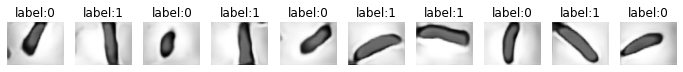

Elapsed Time:1304.334606s
Step 17000 : g_acc=0.421875 d_acc=0.585938


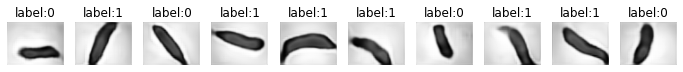

Elapsed Time:1383.258883s
Step 18000 : g_acc=0.421875 d_acc=0.734375


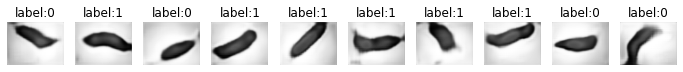

Elapsed Time:1462.229489s
Step 19000 : g_acc=0.437500 d_acc=0.570312


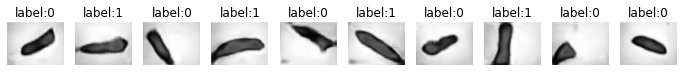

Elapsed Time:1541.016929s
Step 20000 : g_acc=0.312500 d_acc=0.539062


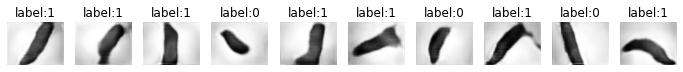

Elapsed Time:1619.420541s
Step 21000 : g_acc=0.093750 d_acc=0.664062


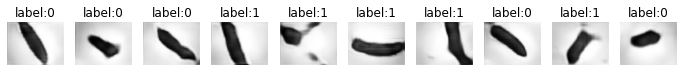

Elapsed Time:1698.403807s
Step 22000 : g_acc=0.609375 d_acc=0.460938


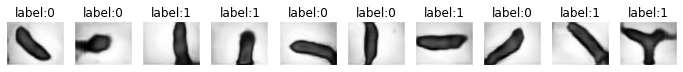

Elapsed Time:1779.112742s
Step 23000 : g_acc=0.390625 d_acc=0.640625


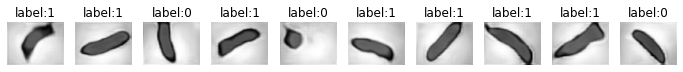

Elapsed Time:1858.698981s
Step 24000 : g_acc=0.218750 d_acc=0.617188


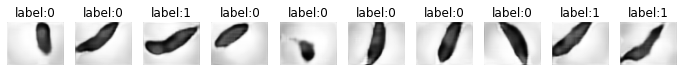

Elapsed Time:1938.376019s
Step 25000 : g_acc=0.343750 d_acc=0.703125


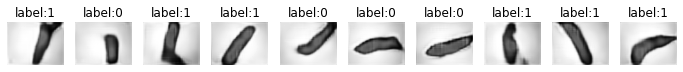

Elapsed Time:2017.798174s
Step 26000 : g_acc=0.343750 d_acc=0.718750


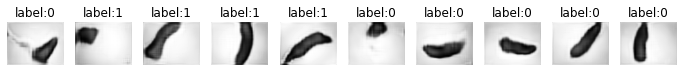

Elapsed Time:2096.514868s
Step 27000 : g_acc=0.328125 d_acc=0.625000


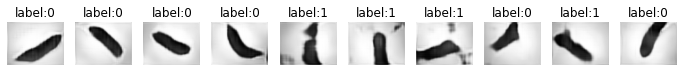

Elapsed Time:2175.207579s
Step 28000 : g_acc=0.078125 d_acc=0.679688


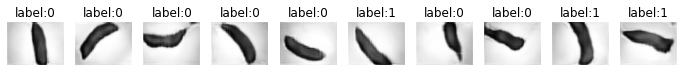

Elapsed Time:2253.834866s
Step 29000 : g_acc=0.515625 d_acc=0.664062


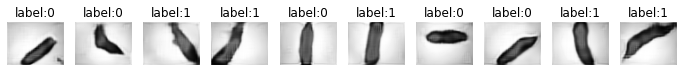

Elapsed Time:2332.177528s
Step 30000 : g_acc=0.109375 d_acc=0.695312


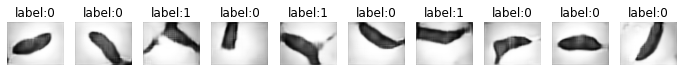

Elapsed Time:2410.702582s
Step 31000 : g_acc=0.375000 d_acc=0.789062


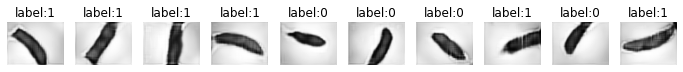

Elapsed Time:2489.207299s
Step 32000 : g_acc=0.406250 d_acc=0.671875


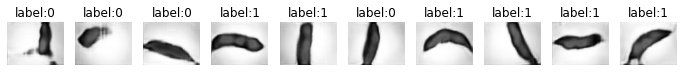

Elapsed Time:2567.494259s
Step 33000 : g_acc=0.406250 d_acc=0.648438


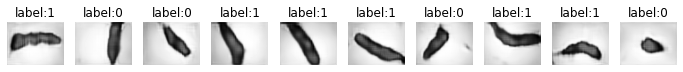

Elapsed Time:2645.918863s
Step 34000 : g_acc=0.359375 d_acc=0.617188


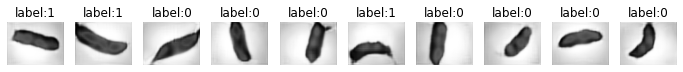

Elapsed Time:2724.750881s
Step 35000 : g_acc=0.140625 d_acc=0.734375


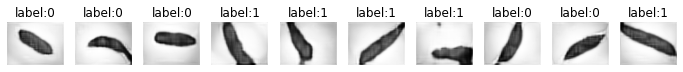

Elapsed Time:2803.087899s
Step 36000 : g_acc=0.140625 d_acc=0.703125


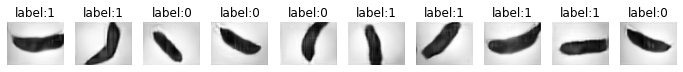

Elapsed Time:2881.771623s
Step 37000 : g_acc=0.265625 d_acc=0.578125


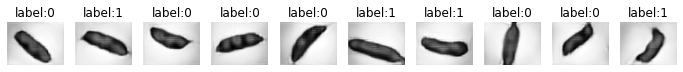

Elapsed Time:2960.826919s
Step 38000 : g_acc=0.125000 d_acc=0.664062


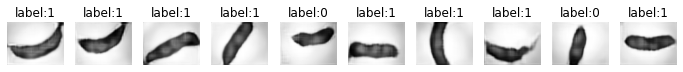

Elapsed Time:3039.953706s
Step 39000 : g_acc=0.656250 d_acc=0.546875


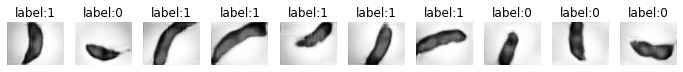

Elapsed Time:3118.804231s
Step 40000 : g_acc=0.437500 d_acc=0.625000


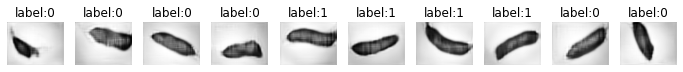

Elapsed Time:3197.848472s
Step 41000 : g_acc=0.421875 d_acc=0.617188


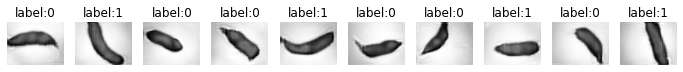

Elapsed Time:3277.367414s
Step 42000 : g_acc=0.593750 d_acc=0.710938


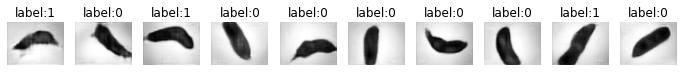

Elapsed Time:3356.370014s
Step 43000 : g_acc=0.187500 d_acc=0.648438


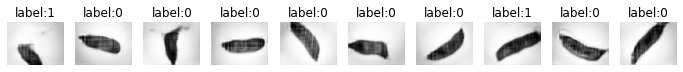

Elapsed Time:3434.855427s
Step 44000 : g_acc=0.203125 d_acc=0.726562


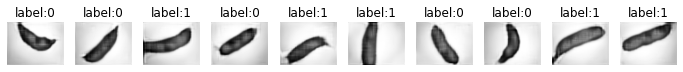

Elapsed Time:3513.532791s
Step 45000 : g_acc=0.156250 d_acc=0.710938


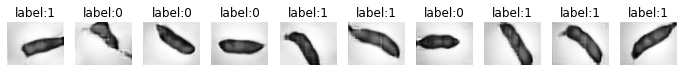

Elapsed Time:3591.916007s
Step 46000 : g_acc=0.468750 d_acc=0.578125


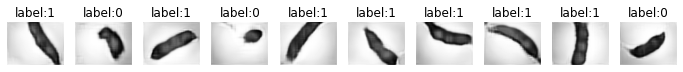

Elapsed Time:3670.471611s
Step 47000 : g_acc=0.343750 d_acc=0.609375


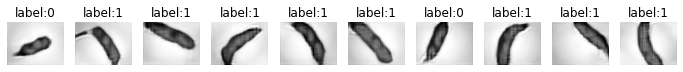

Elapsed Time:3748.897237s
Step 48000 : g_acc=0.390625 d_acc=0.640625


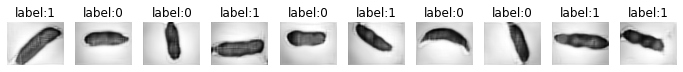

Elapsed Time:3827.128921s
Step 49000 : g_acc=0.281250 d_acc=0.695312


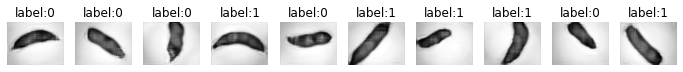

Elapsed Time:3905.345794s
Step 50000 : g_acc=0.171875 d_acc=0.570312


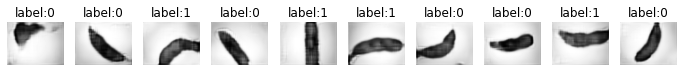

Elapsed Time:3984.127009s
Step 51000 : g_acc=0.312500 d_acc=0.718750


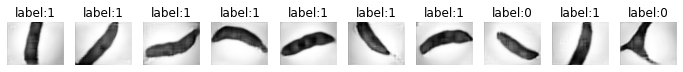

Elapsed Time:4062.515325s
Step 52000 : g_acc=0.203125 d_acc=0.718750


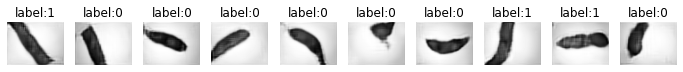

Elapsed Time:4140.827722s
Step 53000 : g_acc=0.453125 d_acc=0.640625


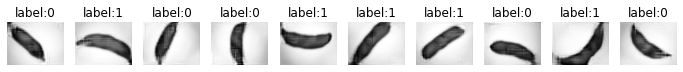

Elapsed Time:4219.346030s
Step 54000 : g_acc=0.218750 d_acc=0.632812


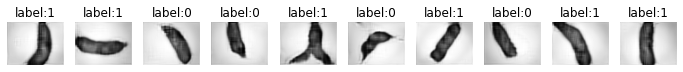

Elapsed Time:4297.873833s
Step 55000 : g_acc=0.250000 d_acc=0.679688


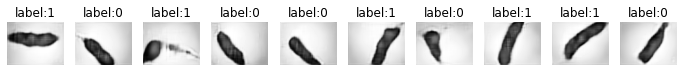

Elapsed Time:4376.052914s
Step 56000 : g_acc=0.453125 d_acc=0.625000


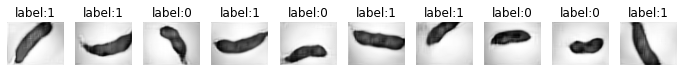

Elapsed Time:4454.257676s
Step 57000 : g_acc=0.562500 d_acc=0.601562


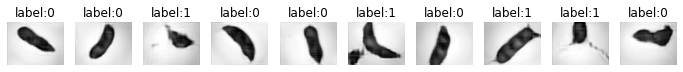

Elapsed Time:4532.442228s
Step 58000 : g_acc=0.250000 d_acc=0.625000


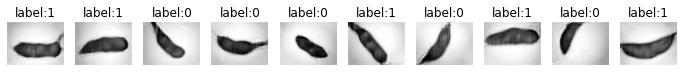

Elapsed Time:4610.724056s
Step 59000 : g_acc=0.421875 d_acc=0.679688


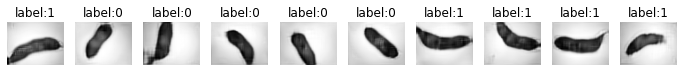

Elapsed Time:4688.890843s
Step 60000 : g_acc=0.406250 d_acc=0.679688


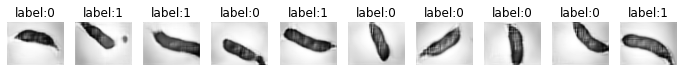

Elapsed Time:4767.255477s


In [7]:
#学習を実行する
#学習には90分ほど要します．学習途中でランタイムが切断された場合は，「再接続」ボタンを押してください．
#長時間ランタイムから切断された状態が続くとリセットされます．
train_gan(max_step=60000, batch_size=64)

### 生成した画像の確認

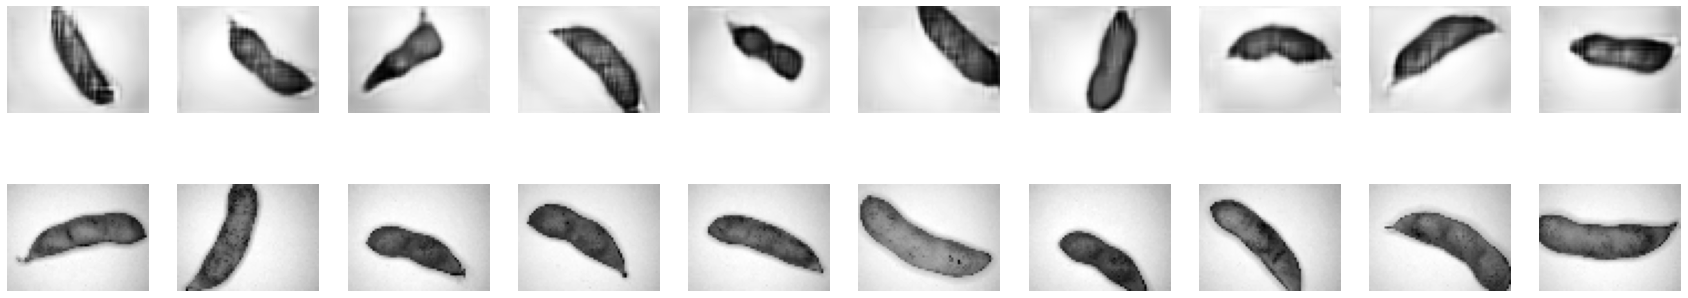

In [8]:
num = 10
cond = 0

noize = np.random.uniform(0, 1, size=[num, 100])
cond_ = np.tile(np.eye(CLASSES)[cond], (num,1))
generated_images = generator.predict([noize, cond_])

fig, ax = plt.subplots(2, num, figsize=(30,6))
for i in range(num):
  if IMAGE_CHANNEL == 1:
    ax[0,i].imshow(generated_images[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
    ax[1,i].imshow(X_train[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
  else:
    ax[0,i].imshow(generated_images[i])
    ax[1,i].imshow(X_train[i])
  ax[0,i].axis('off')
  ax[1,i].axis('off')

plt.show()

### 大量に作ってみる

LABEL 0


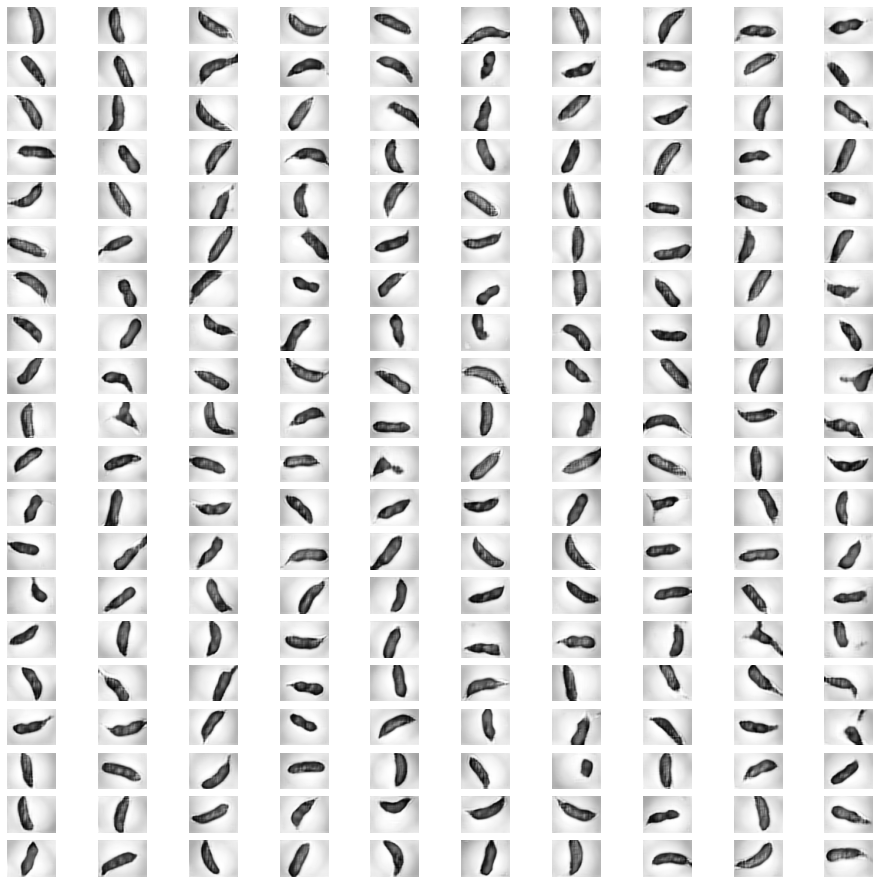

LABEL 1


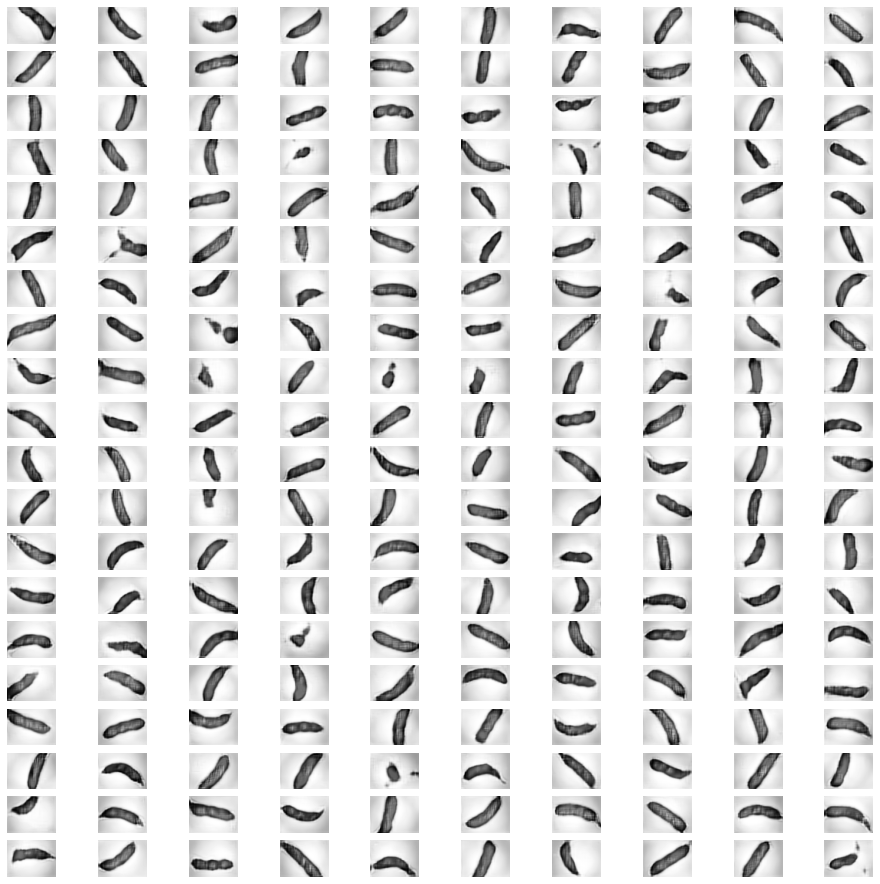

In [9]:
num = 200

for cond in range(CLASSES):
  cond_ = np.tile(np.eye(CLASSES)[cond], (num,1))
  noize = np.random.uniform(0, 1, size=[num, 100])
  generated_images = generator.predict([noize, cond_])

  print("LABEL %d"%(cond))
  fig, ax = plt.subplots(num//10, 10, figsize=(16, 16))
  for i in range(num//10):
    for j in range(10):
      if IMAGE_CHANNEL == 1:
        ax[i, j].imshow(generated_images[i*10+j].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
      else:
        ax[i, j].imshow(generated_images[i*10+j])
      ax[i, j].axis('off')

  plt.show()

# データ拡張手法あれこれ

In [0]:
def draw_sample(x, src):
  num = 5
  x = x[:num]
  src = src[:num]
  print("上段：元の画像　／　下段：変換後の画像")
  fig, ax = plt.subplots(2, num, figsize=(12, 4))
  for i in range(num):
    if IMAGE_CHANNEL == 1:
      ax[0, i].imshow(src[i].reshape(src.shape[1], src.shape[2]), cmap='gray')
      ax[1, i].imshow(x[i].reshape(x.shape[1], x.shape[2]), cmap='gray')
    else:
      ax[0, i].imshow(src[i])
      ax[1, i].imshow(x[i])
    ax[0, i].axis('off')
    ax[1, i].axis('off')
  plt.show()

### １．上下／左右反転

上段：元の画像　／　下段：変換後の画像


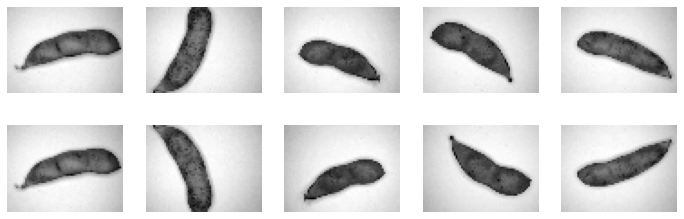

In [11]:
datagen = ImageDataGenerator(
  horizontal_flip=True,
  vertical_flip=True)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ２．垂直／水平シフト

上段：元の画像　／　下段：変換後の画像


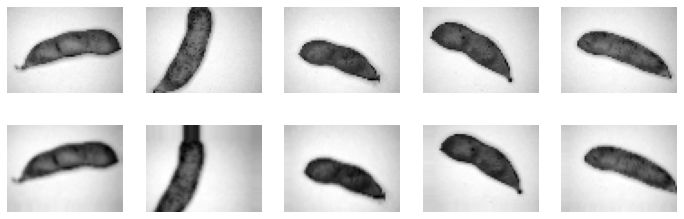

In [12]:
datagen = ImageDataGenerator(
  height_shift_range=0.2,
  width_shift_range=0.2)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ３．画像の回転

上段：元の画像　／　下段：変換後の画像


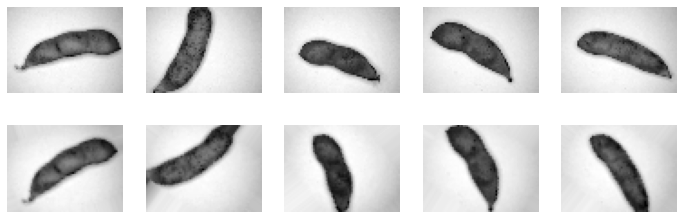

In [13]:
datagen = ImageDataGenerator(
  rotation_range=90)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ４．ズーム

上段：元の画像　／　下段：変換後の画像


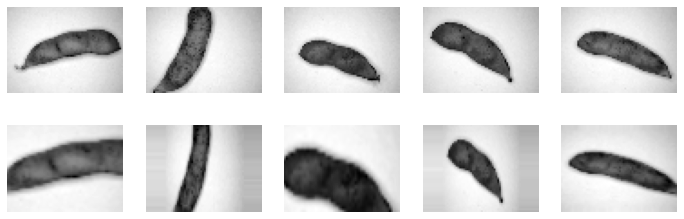

In [14]:
datagen = ImageDataGenerator(
  zoom_range=0.5)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ５．チャネルシフト

上段：元の画像　／　下段：変換後の画像


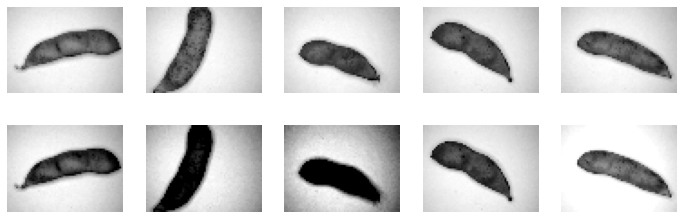

In [15]:
datagen = ImageDataGenerator(
  channel_shift_range=0.6)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ６．画像変形（シアー変換）

上段：元の画像　／　下段：変換後の画像


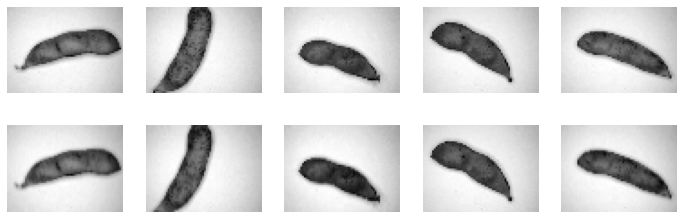

In [16]:
datagen = ImageDataGenerator(
  shear_range=np.pi)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ７．Random Crop

上段：元の画像　／　下段：変換後の画像


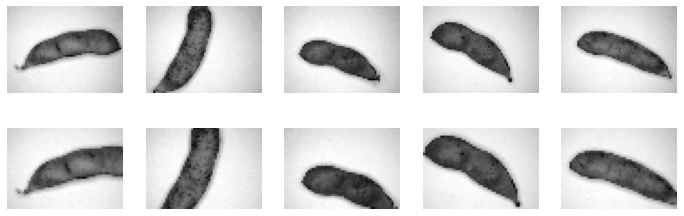

In [17]:
def random_crop(x, size):
  dx = x.shape[2] - size[0]
  dy = x.shape[1] - size[1]
  
  dst = []
  for image in x:
    x = np.random.randint(0, dx)
    y = np.random.randint(0, dy)
    dst.append(image[y:y+size[1],x:x+size[0],:])
  return np.array(dst)
  
cropped = random_crop(X_train, (54, 38))
draw_sample(cropped, X_train)

### ８．Cutout

上段：元の画像　／　下段：変換後の画像


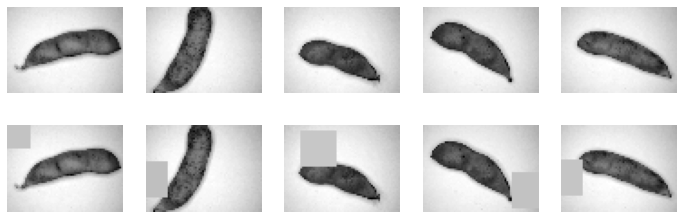

In [18]:
def cutout(image):
  size = image.shape[1] // 3 #マスクサイズは入力画像の1/3
  center_x = np.random.randint(0, image.shape[1])
  center_y = np.random.randint(0, image.shape[0])
  range_w = np.clip((center_x - size//2, center_x + size//2), 0, image.shape[1])
  range_h = np.clip((center_y - size//2, center_y + size//2), 0, image.shape[0])
  image[range_h[0]:range_h[1],range_w[0]:range_w[1],:] = np.mean(image) 
  return image

datagen = ImageDataGenerator(
  preprocessing_function=cutout)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### ９．Random Erasing

上段：元の画像　／　下段：変換後の画像


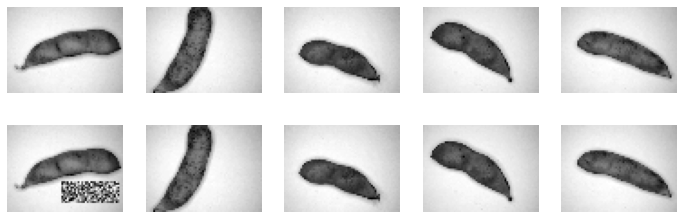

In [19]:
class RandomErasing():
  def __init__(self, p=0.5, sl=0.02, sh=0.4, r1=0.3, r2=3.0):
    self.p = p
    self.sl = sl
    self.sh = sh
    self.r1 = r1
    self.r2 = r2
  
  def transform(self, image):
    if self.p <= np.random.uniform():
      return image
    
    h, w, c = image.shape
    while True:
      se = np.random.uniform(self.sl, self.sh) * (w * h)
      re = np.random.uniform(self.r1, self.r2)
      he = int(np.sqrt(se * re))
      we = int(np.sqrt(se / re))
      
      xe = np.random.randint(0, w)
      ye = np.random.randint(0, h)
      
      if xe + we <= w and ye + he <= h :
        break
        
    image[ye:ye + he, xe:xe + we, :] = np.random.uniform(0, 1.0, size=(he, we, c))
          
    return image
  
datagen = ImageDataGenerator(
  preprocessing_function=RandomErasing().transform)

g = datagen.flow(X_train, shuffle=False)
draw_sample(g.next(), X_train)

### １０．mixup

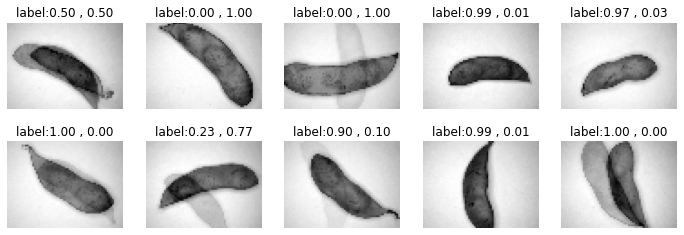

In [20]:
def mixup(images, labels, size=100, alpha=0.2):
  i = np.random.randint(0, images.shape[0], size)
  j = np.random.randint(0, labels.shape[0], size)
  l = np.random.beta(alpha, alpha, size) #Beta分布からsize分のサンプリング

  l_x = l.reshape([size, 1, 1, 1])
  l_y = l.reshape([size, 1])
  
  #size分をランダムに選択
  x_i = images[i]
  y_i = labels[i]
  x_j = images[j]
  y_j = labels[j]
  
  x = x_i * l_x + x_j * (1 - l_x)
  y = y_i * l_y + y_j * (1 - l_y)
  
  return x, y

x, y = mixup(X_train, y_train)
  
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
for i in range(5):
  if IMAGE_CHANNEL == 1:
    ax[0, i].imshow(x[i].reshape(x.shape[1], x.shape[2]), cmap='gray')
    ax[1, i].imshow(x[i+5].reshape(x.shape[1], x.shape[2]), cmap='gray')
  else:
    ax[0, i].imshow(x[i])
    ax[1, i].imshow(x[i+5])
  ax[0, i].axis('off')
  ax[1, i].axis('off')
  ax[0, i].set_title("label:%0.2f , %0.2f"%(y[i][0], y[i][1]))
  ax[1, i].set_title("label:%0.2f , %0.2f"%(y[i+5][0], y[i+5][1]))
plt.show()

# CNNを使った粒数識別器を作る

## モデルの構築

In [0]:
def build_CNN(dropout_rate=0.5, lr=1e-4):
  model_input = Input(shape=[IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL])
  x = Conv2D(32, kernel_size=5, padding='same', kernel_initializer='he_normal')(model_input) #48x64x1->48x64x32
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x) #48x64x32->24x32x32
  x = Conv2D(64, kernel_size=5, padding='same', kernel_initializer='he_normal')(x) #24x32x32->24x32x64
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x) #24x32x64->12x16x64
  x = Conv2D(128, kernel_size=5, padding='same', kernel_initializer='he_normal')(x) #12x16x64->12x16x128
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x) #12x16x128->6x8x128
  x = Flatten()(x) #6x8x128->6*8*128
  x = Dense(256, activation='relu')(x) #6*8*128->256
  x = Dropout(dropout_rate)(x)
  model_output = Dense(CLASSES, activation='softmax')(x) #256->1
  
  model = Model(model_input, model_output)
  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr), metrics=['acc'])
  return model


## 学習

最初に学習結果を表示するための関数を定義します．

In [0]:
def show_history(fit):
  fig , ax = plt.subplots(1, 2, figsize=(12,6))
  ax[0].plot(fit.history['loss'], label='training loss')
  ax[0].plot(fit.history['val_loss'], label='test loss')
  ax[0].set_title("Loss")
  ax[0].set_xlabel("epochs")
  ax[0].set_ylabel("loss")
  ax[0].legend()
  
  ax[1].plot(fit.history['acc'], label='training acc')
  ax[1].plot(fit.history['val_acc'], label='test acc')
  ax[1].set_title("Accuracy")
  ax[1].set_xlabel("epochs")
  ax[1].set_ylabel("accuracy")
  ax[1].legend()

  plt.show()
  
def show_result(model):
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  y = np.argmax(y_test, axis=1)

  matrix = confusion_matrix(y, y_pred)
  print("混同行列")
  print(matrix)

  miss = X_test[y!=y_pred]

  print("間違えた画像")
  fig, ax = plt.subplots(1, 10, figsize=(12, 4))
  for i in range(10):
    if IMAGE_CHANNEL == 1:
      ax[i].imshow(miss[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
    else:
      ax[i].imshow(miss[i])
    ax[i].axis('off')
  plt.show()

  print("Best Accuracy:%f"%(max(history.history['val_acc'])))
  print('F1-Score:%f'%(f1_score(y, y_pred)))

### データ拡張なし

In [23]:
cnn0 = build_CNN()

history = cnn0.fit(X_train, y_train,
                  batch_size = 64,
                  epochs = 200,
                  shuffle=True,
                  validation_data = (X_test, y_test))
cnn0.save('cnn0.h5')

Epoch 1/200
10/10 [==============================] - 0s 37ms/step - loss: 1.2357 - acc: 0.5250 - val_loss: 0.7909 - val_acc: 0.5121
Epoch 2/200
10/10 [==============================] - 0s 14ms/step - loss: 0.6145 - acc: 0.6933 - val_loss: 1.2450 - val_acc: 0.5000
Epoch 3/200
10/10 [==============================] - 0s 14ms/step - loss: 0.5474 - acc: 0.7067 - val_loss: 1.2618 - val_acc: 0.5000
Epoch 4/200
10/10 [==============================] - 0s 14ms/step - loss: 0.4653 - acc: 0.7683 - val_loss: 1.2629 - val_acc: 0.5000
Epoch 5/200
10/10 [==============================] - 0s 14ms/step - loss: 0.4004 - acc: 0.8317 - val_loss: 1.2513 - val_acc: 0.5000
Epoch 6/200
10/10 [==============================] - 0s 14ms/step - loss: 0.3561 - acc: 0.8483 - val_loss: 1.3240 - val_acc: 0.5000
Epoch 7/200
10/10 [==============================] - 0s 13ms/step - loss: 0.3161 - acc: 0.8633 - val_loss: 1.3740 - val_acc: 0.5000
Epoch 8/200
10/10 [==============================] - 0s 14ms/step - loss: 0.

#### 結果

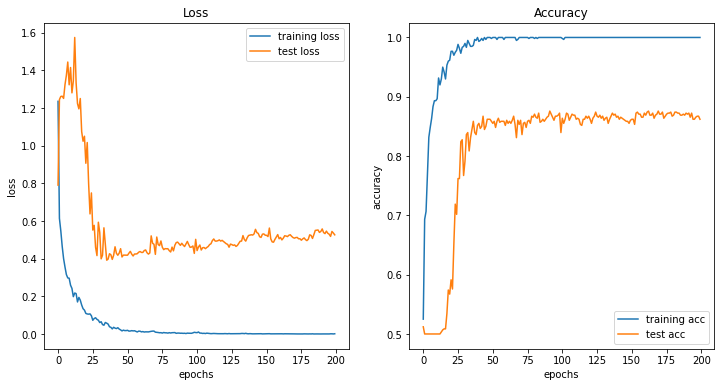

混同行列
[[238  52]
 [ 28 262]]
間違えた画像


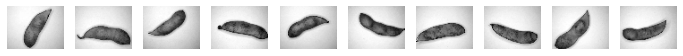

Best Accuracy:0.875862
F1-Score:0.867550


In [24]:
#学習結果の表示
show_history(history)

#間違えたデータを表示
show_result(cnn0)


### 反転と回転によるデータ拡張

In [25]:
cnn1 = build_CNN()
datagen = ImageDataGenerator(rotation_range=60,
                             horizontal_flip=True,
                             vertical_flip=True)

x_aug, y_aug = datagen.flow(X_train, y_train, batch_size=1200).next()

x = np.concatenate([x_aug, X_train])
y = np.concatenate([y_aug, y_train])
history = cnn1.fit(x, y,
                  batch_size = 64,
                  epochs = 200,
                  shuffle=True,
                  validation_data = (X_test, y_test))

cnn1.save("cnn1.h5")

Epoch 1/200
19/19 [==============================] - 0s 21ms/step - loss: 1.2277 - acc: 0.5233 - val_loss: 0.6999 - val_acc: 0.5155
Epoch 2/200
19/19 [==============================] - 0s 12ms/step - loss: 0.6222 - acc: 0.6600 - val_loss: 0.7143 - val_acc: 0.5121
Epoch 3/200
19/19 [==============================] - 0s 12ms/step - loss: 0.5385 - acc: 0.7242 - val_loss: 0.7465 - val_acc: 0.5155
Epoch 4/200
19/19 [==============================] - 0s 12ms/step - loss: 0.4589 - acc: 0.7833 - val_loss: 0.8325 - val_acc: 0.5017
Epoch 5/200
19/19 [==============================] - 0s 12ms/step - loss: 0.4086 - acc: 0.8167 - val_loss: 0.9882 - val_acc: 0.5017
Epoch 6/200
19/19 [==============================] - 0s 12ms/step - loss: 0.3715 - acc: 0.8400 - val_loss: 0.8608 - val_acc: 0.5103
Epoch 7/200
19/19 [==============================] - 0s 11ms/step - loss: 0.3613 - acc: 0.8408 - val_loss: 0.9600 - val_acc: 0.5034
Epoch 8/200
19/19 [==============================] - 0s 12ms/step - loss: 0.

#### 結果

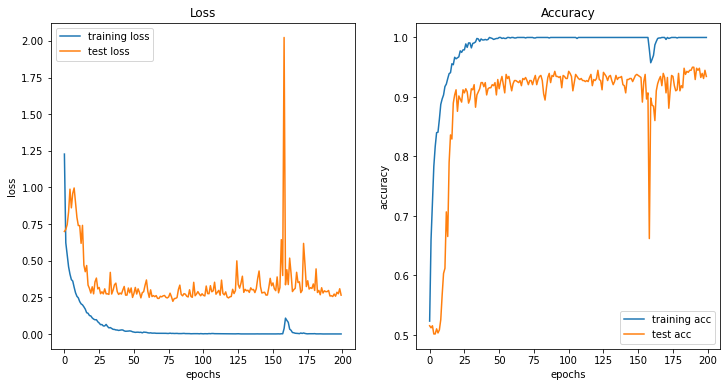

混同行列
[[264  26]
 [ 12 278]]
間違えた画像


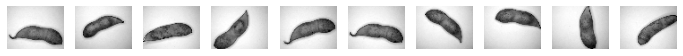

Best Accuracy:0.950000
F1-Score:0.936027


In [26]:
#学習結果の表示
show_history(history)

#間違えたデータを表示
show_result(cnn1)

### mixupの場合

In [27]:
cnn_mixup = build_CNN()

x_aug, y_aug = mixup(X_train, y_train, size=1200)

x = np.concatenate([x_aug, X_train])
y = np.concatenate([y_aug, y_train])
history = cnn_mixup.fit(x, y,
                        shuffle=True,
                        epochs = 200,
                        validation_data = (X_test, y_test))

cnn_mixup.save("cnn_mixup.h5")

Epoch 1/200
57/57 [==============================] - 1s 10ms/step - loss: 0.7133 - acc: 0.6711 - val_loss: 0.7077 - val_acc: 0.5069
Epoch 2/200
57/57 [==============================] - 0s 7ms/step - loss: 0.4205 - acc: 0.8211 - val_loss: 0.8839 - val_acc: 0.5034
Epoch 3/200
57/57 [==============================] - 0s 7ms/step - loss: 0.3351 - acc: 0.8706 - val_loss: 0.7390 - val_acc: 0.5638
Epoch 4/200
57/57 [==============================] - 0s 7ms/step - loss: 0.2788 - acc: 0.9067 - val_loss: 0.5014 - val_acc: 0.7414
Epoch 5/200
57/57 [==============================] - 0s 7ms/step - loss: 0.2315 - acc: 0.9406 - val_loss: 0.3848 - val_acc: 0.8534
Epoch 6/200
57/57 [==============================] - 0s 7ms/step - loss: 0.2051 - acc: 0.9550 - val_loss: 0.3859 - val_acc: 0.8310
Epoch 7/200
57/57 [==============================] - 0s 7ms/step - loss: 0.1769 - acc: 0.9633 - val_loss: 0.3420 - val_acc: 0.8621
Epoch 8/200
57/57 [==============================] - 1s 10ms/step - loss: 0.1689 -

#### 結果

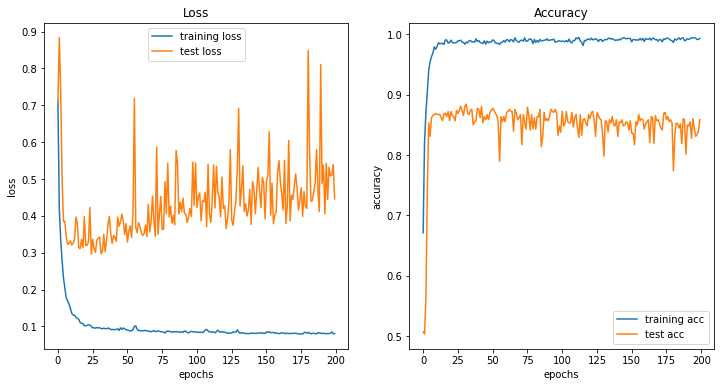

混同行列
[[249  41]
 [ 41 249]]
間違えた画像


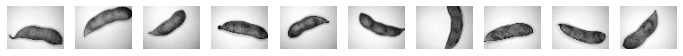

Best Accuracy:0.884483
F1-Score:0.858621


In [28]:
#学習結果の表示
show_history(history)

#間違えたデータを表示
show_result(cnn_mixup)

### GANによるデータ拡張
GANを使ってデータ拡張を行います．Generatorで生成した画像をDiscrimitorで選別して，Discrimitorが本物画像と判断した画像を学習データとして使用します．

In [29]:
#GANを使って仮想データを作る

def create_gan_images(num=5000):
  for i in range(CLASSES):
    cond = np.tile(np.eye(CLASSES)[i], (num,1))
    noize = np.random.uniform(0, 1, size=[num, 100])
    generated_images = generator.predict([noize, cond])
    if i == 0:
      x_gan = generator.predict([noize, cond])
      y_gan = cond
    else:
      x_gan = np.concatenate([x_gan, generated_images])
      y_gan = np.concatenate([y_gan, cond])

  print("generatorが%d枚の画像を生成"%(x_gan.shape[0]))
  return x_gan, y_gan

X_train_gan, y_train_gan = create_gan_images()
print(X_train_gan.shape, y_train_gan.shape)



generatorが10000枚の画像を生成
(10000, 48, 64, 1) (10000, 2)


Discriminatorが本物と判断した枚数：3844
各ラベルから同数取得できる枚数：1602
※この中から各ラベル300枚を使用する
最終的にデータ拡張に使用する生成画像の枚数：600


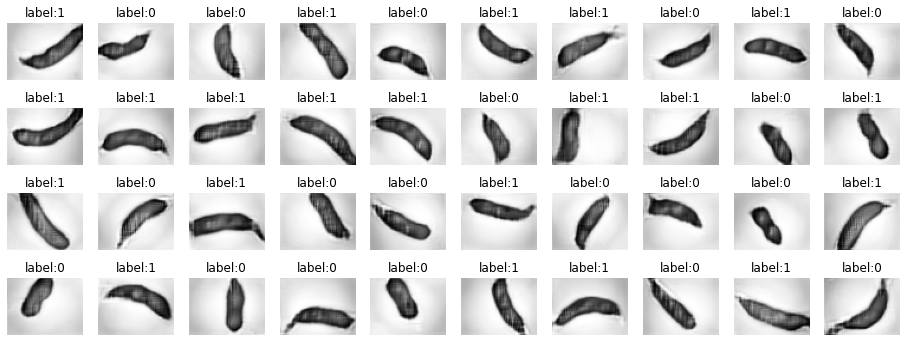

In [30]:

#画像の選別
def select_elaborate(images, labels, disc_model, cnn_model=None, max_num=300):
  #discriminatorで本物と判断したものを選別
  y_ = disc_model.predict([images, labels])
  y_ = y_.argmax(axis=-1)

  x_selected = images[y_==1]
  y_selected = labels[y_==1]
  print("Discriminatorが本物と判断した枚数：%d"%(x_selected.shape[0]))

  if cnn_model is not None:
    #認識精度が高いものを選別
    y_ = cnn_model.predict(x_selected)
    y_ = y_.argmax(axis=-1)
    y_true = y_selected.argmax(axis=-1)

    matrix = confusion_matrix(y_true, y_)
    print("混同行列")
    print(matrix)
  
    valid_num = min([matrix[0][0], matrix[1][1]])

    x_correct = x_selected[y_true==y_]
    y_correct = y_selected[y_true==y_]
    x_selected = x_correct[y_correct.max(axis=-1) > 0.9]
    y_selected = y_correct[y_correct.max(axis=-1) > 0.9]

    print("認識精度が0.9を超えた枚数：%d"%(x_selected.shape[0]))

  #ラベル毎に同数だけ取り出す
  y_true = y_selected.argmax(axis=-1)
  valid_num = min(y_true[y_true==0].shape[0], y_true[y_true==1].shape[0])
  print("各ラベルから同数取得できる枚数：%d"%(valid_num))
  print("※この中から各ラベル%d枚を使用する"%(max_num))

  #データ拡張に使用する枚数は各ラベルmax_num枚とする
  valid_num = max_num if valid_num > max_num else valid_num
  x_selected_0 = x_selected[y_true==0][:valid_num]
  y_selected_0 = y_selected[y_true==0][:valid_num]
  x_selected_1 = x_selected[y_true==1][:valid_num]
  y_selected_1 = y_selected[y_true==1][:valid_num]

  x_selected = np.concatenate([x_selected_0, x_selected_1])
  y_selected = np.concatenate([y_selected_0, y_selected_1])
  print("最終的にデータ拡張に使用する生成画像の枚数：%d"%(x_selected.shape[0]))

  r_index = np.random.permutation(np.arange(x_selected.shape[0]))
  x_selected = x_selected[r_index]
  y_selected = y_selected[r_index]
  
  return x_selected, y_selected

X_train_gan_selected, y_train_gan_selected = select_elaborate(X_train_gan, y_train_gan, discriminator, max_num=300)

#画像の確認
fig, ax = plt.subplots(4, 10, figsize=(16, 6))
for i in range(4):
  for j in range(10):
    if IMAGE_CHANNEL == 1:
        ax[i, j].imshow(X_train_gan_selected[i*10+j].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
    else:
        ax[i, j].imshow(X_train_gan_selected[i*10+j])
    ax[i, j].set_title("label:%d"%(np.argmax(y_train_gan_selected[i*10+j])))
    ax[i, j].axis('off')

plt.show()

In [31]:
#学習
cnn_gan0 = build_CNN()

X_train_gan, y_train_gan = create_gan_images(num=10000)
X_train_gan_selected, y_train_gan_selected = select_elaborate(X_train_gan, y_train_gan, discriminator, max_num=600)

x = np.concatenate([X_train_gan_selected, X_train])
y = np.concatenate([y_train_gan_selected, y_train])
history = cnn_gan0.fit(x, y,
                  batch_size = 64,
                  epochs = 200,
                  shuffle=True,
                  validation_data = (X_test, y_test))

cnn_gan0.save("cnn_gan0.h5")

generatorが20000枚の画像を生成
Discriminatorが本物と判断した枚数：7528
各ラベルから同数取得できる枚数：3134
※この中から各ラベル600枚を使用する
最終的にデータ拡張に使用する生成画像の枚数：1200
Epoch 1/200
29/29 [==============================] - 0s 14ms/step - loss: 0.8955 - acc: 0.6167 - val_loss: 0.6924 - val_acc: 0.5362
Epoch 2/200
29/29 [==============================] - 0s 10ms/step - loss: 0.5057 - acc: 0.7600 - val_loss: 0.6774 - val_acc: 0.6069
Epoch 3/200
29/29 [==============================] - 0s 11ms/step - loss: 0.4465 - acc: 0.7867 - val_loss: 0.9643 - val_acc: 0.5000
Epoch 4/200
29/29 [==============================] - 0s 11ms/step - loss: 0.3648 - acc: 0.8417 - val_loss: 1.0546 - val_acc: 0.5000
Epoch 5/200
29/29 [==============================] - 0s 11ms/step - loss: 0.3384 - acc: 0.8572 - val_loss: 0.7596 - val_acc: 0.5741
Epoch 6/200
29/29 [==============================] - 0s 11ms/step - loss: 0.3417 - acc: 0.8550 - val_loss: 0.6764 - val_acc: 0.6500
Epoch 7/200
29/29 [==============================] - 0s 11ms/step - loss: 0.2779 - acc: 

#### 結果

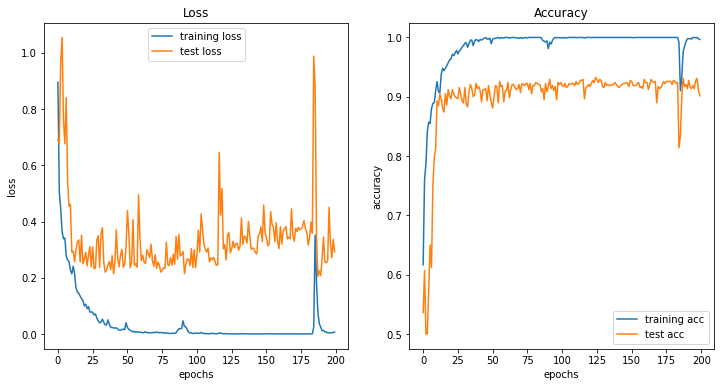

混同行列
[[251  39]
 [ 18 272]]
間違えた画像


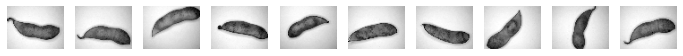

Best Accuracy:0.932759
F1-Score:0.905158


In [32]:
show_history(history)

#間違えたデータを表示
show_result(cnn_gan0)

### 反転と回転＋GANによるデータ拡張

In [33]:
#学習
cnn_gan1 = build_CNN()

X_train_gan, y_train_gan = create_gan_images(num=10000)
X_train_gan_selected, y_train_gan_selected = select_elaborate(X_train_gan, y_train_gan, discriminator, max_num=300)

x_ = np.concatenate([X_train_gan_selected, X_train])
y_ = np.concatenate([y_train_gan_selected, y_train])

datagen = ImageDataGenerator(rotation_range=60,
                             horizontal_flip=True,
                             vertical_flip=True)

x_aug, y_aug = datagen.flow(x_, y_, batch_size=1200).next()

x = np.concatenate([x_aug, X_train])
y = np.concatenate([y_aug, y_train])
history = cnn_gan1.fit(x, y,
                  batch_size = 64,
                  epochs = 200,
                  shuffle=True,
                  validation_data = (X_test, y_test))

cnn_gan1.save("cnn_gan1.h5")

generatorが20000枚の画像を生成
Discriminatorが本物と判断した枚数：7443
各ラベルから同数取得できる枚数：3073
※この中から各ラベル300枚を使用する
最終的にデータ拡張に使用する生成画像の枚数：600
Epoch 1/200
29/29 [==============================] - 0s 14ms/step - loss: 0.9216 - acc: 0.5494 - val_loss: 0.7856 - val_acc: 0.5000
Epoch 2/200
29/29 [==============================] - 0s 11ms/step - loss: 0.5851 - acc: 0.6839 - val_loss: 0.8596 - val_acc: 0.5017
Epoch 3/200
29/29 [==============================] - 0s 11ms/step - loss: 0.5168 - acc: 0.7372 - val_loss: 0.7067 - val_acc: 0.5293
Epoch 4/200
29/29 [==============================] - 0s 11ms/step - loss: 0.4319 - acc: 0.7956 - val_loss: 0.7374 - val_acc: 0.5328
Epoch 5/200
29/29 [==============================] - 0s 11ms/step - loss: 0.3967 - acc: 0.8306 - val_loss: 0.7404 - val_acc: 0.5672
Epoch 6/200
29/29 [==============================] - 0s 10ms/step - loss: 0.3323 - acc: 0.8628 - val_loss: 0.7355 - val_acc: 0.5948
Epoch 7/200
29/29 [==============================] - 0s 11ms/step - loss: 0.3455 - acc: 0

#### 結果

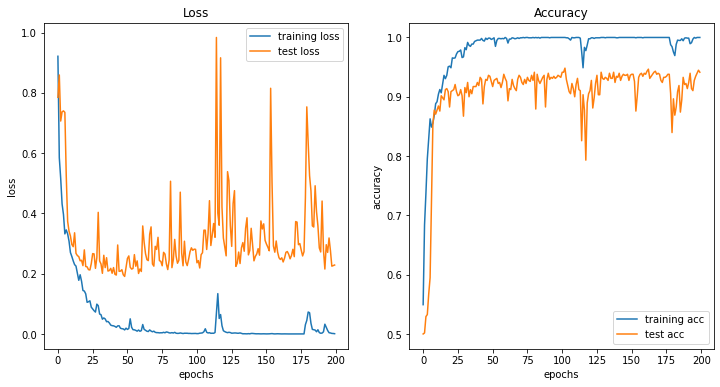

混同行列
[[272  18]
 [ 16 274]]
間違えた画像


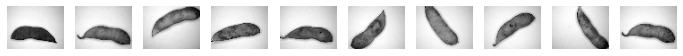

Best Accuracy:0.948276
F1-Score:0.941581


In [34]:
show_history(history)

#間違えたデータを表示
show_result(cnn_gan1)

# 学習済みモデルのダウンロード

In [36]:
import os
from google.colab import files

!ls
files.download('generator.h5')
files.download('combined_model.h5')
files.download('discrimitor.h5')
files.download('cnn0.h5')
files.download('cnn1.h5')
files.download('cnn_mixup.h5')
files.download('cnn_gan0.h5')
files.download('cnn_gan1.h5')


cnn0.h5  cnn_gan0.h5  cnn_mixup.h5	 discrimitor.h5  sample_data
cnn1.h5  cnn_gan1.h5  combined_model.h5  generator.h5	 soybeans_dataset.npz
